# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

👋 Welcome to "🧠Exploring EEG: A Beginner's Guide"! 

If you're fascinated by the wonders of the human brain and the intricate patterns of brainwaves, but find the world of Electroencephalography (EEG) analysis daunting, you're in the right place. 

This notebook is designed for beginners like me & you, aiming to demystify the complexities of EEG data and make your learning journey both enjoyable and informative.

### <b><span style='color:#FFCE30'> 1.1 |</span> Intention of the notebook</b>
In this notebook, we will embark on an exploratory journey into the realm of EEG data analysis. Our goal is to provide a clear, step-by-step guide to understanding and analyzing EEG signals, which are crucial in detecting and classifying brain activities, such as seizures. We aim to:

* Break down complex concepts into easily digestible sections.
* Illustrate each step with practical code examples.
* Reference public notebooks and discussions to enhance your learning experience.


### <b><span style='color:#FFCE30'> 1.2 |</span> Learning Objective</b>
By the end of this notebook, you will have a foundational understanding of:

* The basics of EEG signals and their significance in medical research and neurology.
* How to preprocess and analyze EEG data.
* Run through the basic code to build a machine learning model for EEG data classification.

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>2 |</span></b> <b>REFERENCE & ACKNOWLEDGEMENT</b></div>

This notebook wouldn't be possible without the valuable insights and contributions from the Kaggle community. I've leveraged several resources to compile the most effective learning path for us:

* https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-8
* https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
* https://www.kaggle.com/code/ksooklall/hms-banana-montage
* https://www.kaggle.com/code/mpwolke/seizures-classification-parquet


Feel free to explore these resources alongside this notebook to deepen your understanding.

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>3 |</span></b> <b>DOMAIN UNDERSTANDING</b></div>

<b><span style='color:#FFCE30'> 3.1 |</span> Background of EEG</b>

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>4 |</span></b> <b>LOAD LIBARIES</b></div>

In [1]:
import os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
VER = 1

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>LOAD TRAIN DATA</b></div>

In [2]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>6 |</span></b> <b>CREATE NON-OVERLAPPING EEG ID TRAIN DATA</b></div>

Following the notebook from Chris Deotte: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-8,
Initial discussion found here https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

We perform the following because:

* **Match Training Data with Test Data Format:** The competition states that the test data does not have multiple segments from the same eeg_id. To make the training data similar to the test data, we also use only one segment per eeg_id in the training data.

* **Remove Redundancies:** This approach ensures that the training data does not have overlapping or redundant information, which can lead to a more accurate and generalizable machine learning model.

* **Consistency in Data:** By standardizing how we handle the EEG segments in training, we ensure that our model learns from data that is consistent in format with the data it will be tested on.

* **Data Preparation for Machine Learning:** The normalization of target variables and inclusion of relevant features like patient_id and expert_consensus prepare the dataset for effective machine learning modeling.

In [3]:
# Creating a Unique EEG Segment per eeg_id:
# The code groups (groupby) the EEG data (df) by eeg_id. Each eeg_id represents a different EEG recording.
# It then picks the first spectrogram_id and the earliest (min) spectrogram_label_offset_seconds for each eeg_id. This helps in identifying the starting point of each EEG segment.
# The resulting DataFrame train has columns spec_id (first spectrogram_id) and min (earliest spectrogram_label_offset_seconds).
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']


# Finding the Latest Point in Each EEG Segment:
# The code again groups the data by eeg_id and finds the latest (max) spectrogram_label_offset_seconds for each segment.
# This max value is added to the train DataFrame, representing the end point of each EEG segment.
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp


tmp = df.groupby('eeg_id')[['patient_id']].agg('first') # The code adds the patient_id for each eeg_id to the train DataFrame. This links each EEG segment to a specific patient.
train['patient_id'] = tmp


tmp = df.groupby('eeg_id')[TARGETS].agg('sum') # The code sums up the target variable counts (like votes for seizure, LPD, etc.) for each eeg_id.
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values # It then normalizes these counts so that they sum up to 1. This step converts the counts into probabilities, which is a common practice in classification tasks.
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first') # For each eeg_id, the code includes the expert_consensus on the EEG segment's classification.
train['target'] = tmp

train = train.reset_index() # This makes eeg_id a regular column, making the DataFrame easier to work with.
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>FEATURE ENGINEERING</b></div>

* The code belows efficiently reads spectrogram data, from a single combined file, based on the set variable. We relied on the dataset by Chris Deotte to save time. https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
* It then performs feature engineering by calculating mean and minimum values over two different time windows for each frequency in the spectrogram.
It produce produces in 1600 features (400 features × 4 calculations) for each EEG ID.
* The new features are intended to help the model better understand and classify the EEG data.
* This approach is designed to enhance the model's performance by providing it with more detailed information derived from the spectrogram data.

In [4]:
READ_SPEC_FILES = False # If READ_SPEC_FILES is False, the code reads the combined file instead of individual files.
FEATURE_ENGINEER = True

In [5]:
%%time
# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 4.94 s, sys: 12.3 s, total: 17.2 s
Wall time: 1min 18s


In [6]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# The code generates features from the spectrogram data for use in a model 
# The features are derived by calculating the mean and minimum values over time for each of the 400 spectrogram frequencies.
# Two types of windows are used for these calculations:
# A 10-minute window (_mean_10m, _min_10m).
# A 20-second window (_mean_20s, _min_20s).
# This process results in 1600 features (400 features × 4 calculations) for each EEG ID.

SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')


# A data matrix data is initialized to store the new features for each eeg_id in the train DataFrame.
# For each row in train, the code calculates the mean and minimum values within the specified 10-minute and 20-second windows.
# These calculated values are then stored in the data matrix.
# Finally, the matrix is added to the train DataFrame as new columns.

if FEATURE_ENGINEER:
    data = np.zeros((len(train),len(FEATURES)))
    for k in range(len(train)):
        if k%100==0: print(k,', ',end='')
        row = train.iloc[k]
        r = int( (row['min'] + row['max'])//4 ) 
        
        # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,:400] = x
        x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,400:800] = x
        
        # 20 SECOND WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,800:1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,1200:1600] = x

    train[FEATURES] = data
else:
    train = pd.read_parquet('/kaggle/input/brain-spectrograms/train.pqt')
print()
print('New train shape:',train.shape)

CPU times: user 4 µs, sys: 8 µs, total: 12 µs
Wall time: 17.2 µs
We are creating 1600 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 ,

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>8 |</span></b> <b>TRAIN MODEL</b></div>

* Original work uses catboost, let's try with XGBoost in this version to see the difference.

In [7]:
import xgboost as xgb
import gc
from sklearn.model_selection import KFold, GroupKFold

print('XGBoost version', xgb.__version__)

XGBoost version 2.0.3


In [8]:
all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = xgb.XGBClassifier(
        objective='multi:softprob', 
        num_class=len(TARS),
        #tree_method='gpu_hist',  # Did not use GPU acceleration
    )
    
    # Prepare training and validation data
    X_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'target'].map(TARS)
    X_valid = train.loc[valid_index, FEATURES]
    y_valid = train.loc[valid_index, 'target'].map(TARS)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=True, 
              early_stopping_rounds=10)
    model.save_model(f'XGB_v{VER}_f{i}.model')
    
    oof = model.predict_proba(X_valid)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)
    
    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
[0]	validation_0-mlogloss:1.58320
[1]	validation_0-mlogloss:1.46502
[2]	validation_0-mlogloss:1.38201
[3]	validation_0-mlogloss:1.32699
[4]	validation_0-mlogloss:1.28679
[5]	validation_0-mlogloss:1.25532
[6]	validation_0-mlogloss:1.23440
[7]	validation_0-mlogloss:1.21801
[8]	validation_0-mlogloss:1.19913
[9]	validation_0-mlogloss:1.18848
[10]	validation_0-mlogloss:1.17942
[11]	validation_0-mlogloss:1.16932
[12]	validation_0-mlogloss:1.16292
[13]	validation_0-mlogloss:1.15685
[14]	validation_0-mlogloss:1.15368
[15]	validation_0-mlogloss:1.15029
[16]	validation_0-mlogloss:1.14546
[17]	validation_0-mlogloss:1.15009
[18]	validation_0-mlogloss:1.14598
[19]	validation_0-mlogloss:1.14521
[20]	validation_0-mlogloss:1.14319
[21]	validation_0-mlogloss:1.14254
[22]	validation_0-mlogloss:1.14202
[23]	validation_0-mlogloss:1.14350
[24]	validation_0-mlogloss:1.14749
[25]	validation_0-mlogloss:1.14480

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>9 |</span></b> <b>FEATURE IMPORTANCE</b></div>

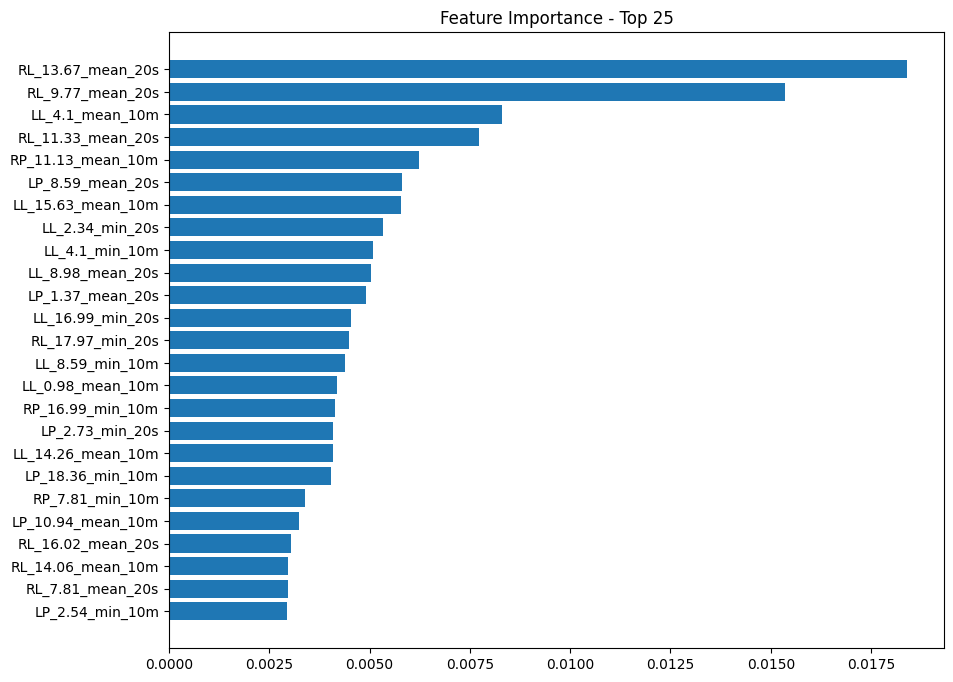

In [9]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>10 |</span></b> <b>INFER TEST</b></div>

In [10]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [11]:
# FEATURE ENGINEER TEST
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
data = np.zeros((len(test),len(FEATURES)))
    
for k in range(len(test)):
    row = test.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x

test[FEATURES] = data
print('New test shape',test.shape)

New test shape (1, 1603)


In [12]:
# INFER XGBOOST ON TEST
preds = []

for i in range(5):
    print(i, ', ', end='')
    
    # Load the XGBoost model
    model = xgb.XGBClassifier()
    model.load_model(f'XGB_v{VER}_f{i}.model')
    
    # Make predictions
    pred = model.predict_proba(test[FEATURES])
    preds.append(pred)

# Average the predictions from each fold
pred = np.mean(preds, axis=0)
print()
print('Test preds shape', pred.shape)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>11 |</span></b> <b>SUBMISSION</b></div>

In [13]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.122414,0.08784,0.007696,0.122652,0.044978,0.61442


In [14]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32